In [19]:
import os
import sys

WDIR = '/home/jdv/code/activmask/activmask'
sys.path.insert(0, os.path.dirname(WDIR))
os.chdir(WDIR)

from activmask.datasets.msdd import HeartMSDDataset, LiverMSDDataset, PancreasMSDDataset
from activmask.datasets.synth import SyntheticDataset
from activmask.datasets.xray import JointDataset
from activmask.models.loss import compare_activations, get_grad_contrast
from activmask.models.resnet import ResNetModel
from collections import OrderedDict
from copy import copy
from glob import glob
from skimage import io
from sklearn.decomposition import PCA
from textwrap import wrap
import argparse
import datetime
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint
import random
import seaborn as sns
import time
import torch
import torch.nn as nn
import yaml

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# GLOBALS
SEEDS=[1234, 3232, 3221, 9856, 1290, 1987, 3200, 6400, 8888, 451]

In [21]:
# FUNCTIONS TO DEPRECATE
def plot_curves(df, mode='test'):
    """Plots the test AUC over epochs for an experiment table."""
    
    import warnings
    raise warnings.DeprecationWarning("Not using this anymore, using Seaborn Plotting tools instead!")    
    
    EPOCH = 499
    EXPERIMENTS = ['unet', 'ae', 'resnet', 'cnn']
    EXP_NAMES = ["UNet", "Autoencoder", "ResNet 18", "ConvNet"]

    assert mode in ['test', 'train', 'valid']
    
    fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
    ax = ax.ravel()
    
    for i, (exp, exp_name) in enumerate(zip(EXPERIMENTS, EXP_NAMES)):
        
        ls = ['solid', 'dashed', 'dashdot', 'dotted', '-' ,'--' ,'-.' , ':','None' ,' ' ,'' ]
        dfs = df.reindex()

        # Filter by experiment.
        dfs = dfs[dfs['experiment_name'].str.contains(exp)]

        for j, name in enumerate(sorted(dfs.experiment_name.unique())):
 
            thisdata = dfs[dfs["experiment_name"] == name]
            willplot = thisdata.groupby(["epoch"]).mean()
            r = willplot.plot(y="{}_auc".format(mode), 
                              ax=ax[i], label=name, ls=ls[j])

        patches, labels = ax[i].get_legend_handles_labels()
 
        ax[i].legend(patches, labels, loc='lower right', title="experiment")    
        ax[i].set_ylim(-0.05, 1.05)  
        ax[i].set_ylabel("AUC")  
        ax[i].set_xlabel("Epoch")

        ax[i].set_title("{} Experiments".format(exp_name))
        fig.set_tight_layout(tight=True)
        
        
#def get_search_results_at_epoch(df, epoch):
#    """Get the test results at the best epoch."""
#    cols = ['experiment_name', 'best_valid_auc', 'optimizer_lr']
#    groups = ['experiment_name', 'optimizer_lr']
#    
#    return get_results_at_epoch(df, epoch, groups, cols, mode='max')


#def get_mask_results_at_epoch(df, epoch):
#    """
#    Get the results of the maxmask experiments at a given epoch. Not used currently.
#    """
#    groups = ["experiment_name", "epoch", "train_dataset_maxmasks"]
#    cols = ["best_test_auc", "best_epoch"]
#    
#    return get_results_at_epoch(df, epoch, groups, cols)


Functions
---------------

In [22]:
def convert_dtype(dictionary):
    """
    Converts all entries in all subdictionaries to be of datatype
    [int, float, str]. All non-matching entries are converted to str.
    """
    TYPES = [float, int, str, np.float32, np.float64, bool]
    
    for d in dictionary:
        if type(d) == dict:
            d = convert_dtype(d)
        else:
            if type(dictionary[d]) not in TYPES:
                dictionary[d] = str(dictionary[d])


def load_model(model_path):
    """ Loads a checkpointed model to the CPU. 
    Note: this is very sensitive to the path. Check the current directory
    is set correctly in the import statements if you get 'module not found'
    errors.
    """
    return torch.load(model_path, map_location='cpu')


def get_metrics(path, best=False):
    """
    Loads the outputs of training, if best, only 
    keeps best epoch for each dataframe.
    """
    all_df = [] 
    for f in glob(os.path.join(path, "*/stats_*.pkl")):
        d = pickle.load(open(f,"rb"))
        convert_dtype(d)
        d = pd.DataFrame.from_dict(d)
                
        if best:
            # Offset by 1 because of a bug in how "best" stats are stored.
            # Data at best_epoch are all actually the second-best epoch.
            best_epoch = d.iloc[-1]['best_epoch']
            d = d[d['this_epoch'] == best_epoch]

        all_df.append(d)

    return pd.concat(all_df)


def df_cleaner(df, keep=['auc', 'seed'], remove=[], verbose=True):
    """Selects the columns of the metrics dataframe to keep."""
    for col in df.columns:
        if not any([string in col for string in keep]):
            del df[col]
        elif any([string in col for string in remove]):
            del df[col]
            
    # Experiment name is determined by the configuration file used.
    experiments = df.experiment_name.unique()

    if verbose:
        print("resulting df \nshape={} tracking {} experiments, \nexperiments={}".format(
            df.shape, len(experiments), df.experiment_name.unique()))

    return(df)


def df_experiment_filter(df, name):
    return df[df['experiment_name'].str.contains(name)]


def get_performance_metrics(path, best=False):
    KEEP = ["auc", "best", "seed", "epoch", "name", "maxmasks"]

    return df_cleaner(get_metrics(path, best=best), keep=KEEP)


def get_best_hyperparameters(path):
    KEEP = ['name', 'blur', 'actdiff', 'disc', 'gradmask', 'lr', 'type', 'acts']
    FILTER = ['loss']
    df =  df_cleaner(get_metrics(path, best=True), keep=KEEP, remove=FILTER)
    df =  df[df['experiment_name'].str.contains('search')]
    return df
    

def get_last_results_at_epoch(df, epoch, sig_digits=3):
    """Get the train/test/valid AUC at the final, not best, epoch."""
    #groups = ['experiment_name', 'actdiff_lambda', 'recon_lambda']
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"
    
    groups = ['experiment_name']
    cols = ['train_auc', 'valid_auc', 'best_epoch']
    
    df = get_results_at_epoch(df, epoch, groups, cols)
    df = df.round(sig_digits)
    
    results = [] 
    for a, b in zip(df["train_auc"], df["train_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['train_auc'] = results 
    df = df.drop(['train_auc_std'], axis=1)

    results = [] 
    for a, b in zip(df["valid_auc"], df["valid_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['valid_auc'] = results 
    df = df.drop(['valid_auc_std'], axis=1)
    
    results = [] 
    for a, b in zip(df["best_epoch"], df["best_epoch_std"]):
        results.append(fmt_str.format(a, b))
    df['best_epoch'] = results 
    df = df.drop(['best_epoch_std'], axis=1)
    
    return df


def make_results_table(dfs, sig_digits=3, count=False):
    """
    Merge the best test results for all dataframes submitted. 
    Used to make a results table across datasets.
    """
    
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"
    for i, df in enumerate(dfs):
        tmp_df = copy(df)
        
        # Strip the dataset name out of the experiment name.        
        name = tmp_df['experiment_name'].iloc[0].split('_')[0]
        tmp_df['experiment_name'] = tmp_df['experiment_name'].str.replace('{}_'.format(name), '')
        
        # Reformat the table.
        tmp_df = get_test_results(tmp_df, count=count)
        tmp_df = tmp_df.round(sig_digits)

        # Merge mean+/-std into a single column with the experiment name.
        results = [] 
        for a, b in zip(tmp_df["best_test_auc"], tmp_df["best_test_auc_std"]):
            results.append(fmt_str.format(a, b))
        tmp_df['test_auc_{}'.format(name)] = results 
        tmp_df = tmp_df.drop(['best_test_auc', 'best_test_auc_std'], axis=1)

        print(tmp_df)
        
        # Merge the experiments.
        if i == 0:
            final_df = copy(tmp_df)
        else:
            final_df = pd.merge(final_df, tmp_df, on='experiment_name')
    
    return final_df


def get_results(df, groups, cols, count=False, mode='mean'):
    """
    Shows a reduced form of the table with mean and std values 
    over experiments.
    """
    df_tmp = df.groupby(groups)[cols]
    if mode == 'mean':
        df = df_tmp.mean().join(df_tmp.std(),rsuffix='_std')
    elif mode == 'max':
        df = df_tmp.max().join(df_tmp.std(),rsuffix='_std')
    if count:
        df = df.join(df_tmp.count(), rsuffix='_count')
                                                                        
    return df


def get_test_results(df, count=False):
    """Get the test results at the best epoch."""
    groups = ['experiment_name']
    cols = ['best_test_auc']
    
    return get_results(df, groups, cols, count=count, mode='mean')


def get_lineplot_df(input_df, epoch):
    """
    Gets a dataframe useful for the lineplots below.
    """
    df = copy(input_df)
    df = df[(df.epoch==EPOCH)]
    idx = ~df['experiment_name'].str.contains('cnn')
    df = df[idx]
    idx = ~df['experiment_name'].str.contains('_ae_')
    return df[idx]


def get_curveplot_df(input_df, mode):
    """
    Gets a dataframe useful for the curveplots below.
    """
    df = copy(input_df)
    idx = df['experiment_name'].str.contains(mode)
    return df[idx]


def read_img(exp):
    """Reads best epoch images that are generated by the training loop."""
    file = glob("../images/{}/image-best_valid-*.png".format(exp))
    image = io.imread(file[0])
    plt.imshow(image)
    plt.show();
    
def merge_dfs_for_maxmasks(df, df_mask, old_prefix, new_prefix, actdiff_lamb):
    tmp_resnet_act = df[df['experiment_name'] == '{}_resnet'.format(old_prefix)]
    tmp_resnet_act['experiment_name'] = '{}_resnet_actdiff'.format(new_prefix)
    tmp_resnet_act['maxmasks_train'] = 0
    tmp_resnet_act['actdiff_lambda'] = actdiff_lamb
    tmp_resnet_grd = df[df['experiment_name'] == '{}_resnet'.format(old_prefix)]
    tmp_resnet_grd['experiment_name'] = '{}_resnet_gradmask'.format(new_prefix)
    tmp_resnet_grd['maxmasks_train'] = 0
    tmp_resnet_grd['actdiff_lambda'] = 0
    tmp_unet_act = df[df['experiment_name'] == '{}_unet'.format(old_prefix)]
    tmp_unet_act['experiment_name'] = '{}_unet_actdiff'.format(new_prefix)
    tmp_unet_act['maxmasks_train'] = 0
    tmp_unet_act['actdiff_lambda'] = actdiff_lamb
    tmp_unet_grd = df[df['experiment_name'] == '{}_unet'.format(old_prefix)]
    tmp_unet_grd['experiment_name'] = '{}_unet_gradmask'.format(new_prefix)
    tmp_unet_grd['maxmasks_train'] = 0
    tmp_unet_grd['actdiff_lambda'] = 0
    df_mask = pd.concat([df_mask, tmp_resnet_act, tmp_resnet_grd, tmp_unet_act, tmp_unet_grd])
    
    return df_mask


def seed_finder(df, experiment_name):
    test = df[df.epoch == EPOCH]
    test = test[test['experiment_name'] == experiment_name]

    for seed in SEEDS:
        if seed not in np.array(test['seed']):
            print("{} missing {}".format(experiment_name, seed))

# Plotting

In [23]:
def render_salience_maps(text, idx, sample, sample_blur, modelz, exp_name, blur):

    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 8), dpi=150, gridspec_kw={'hspace': 0.15, 'wspace': 0.01})
    fig.subplots_adjust(wspace=0.0)
    for a in ax:
        for aa in a:
            aa.axis('off')

    x, target, use_mask = sample
    img = x[0][0].cpu().numpy()
    #img = img / np.max(img)
    seg = x[1][0].cpu().numpy() 
    seg_blur = sample_blur[0][1][0]
    
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),requires_grad=True)
    
    ax[0,0].set_title(str(idx) + "Image")
    ax[0,0].imshow(img, interpolation='none', cmap='Greys_r')
    ax[0,0].axis('off')    
    
    ax[0,1].set_title('Pathology + Mask (blur={})'.format(blur))
    ax[0,1].imshow((1-seg_blur).numpy()+(1-seg), cmap="Greys_r", interpolation='none')
    ax[0,1].axis('on')
    ax[0,1].get_xaxis().set_ticks([])
    ax[0,1].get_yaxis().set_ticks([])

    my_cmap = plt.cm.jet
    my_cmap.set_under('k', alpha=0)
    
    name = "UNet Masked"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,4].set_title(name)
    ax[2,4].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,4].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,4].axis('off')  
    ax[1,4].set_title("Unet Masked Recon")
    ax[1,4].imshow(x_prime.detach().numpy()[0][0], interpolation='none', cmap='Greys_r')
    ax[1,4].axis('off')  
    
    name = "UNet Baseline"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,0].set_title(name)
    ax[2,0].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,0].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,0].axis('off')
    ax[0,4].set_title("Unet Baseline Recon")
    ax[0,4].imshow(x_prime.detach().numpy()[0][0], interpolation='none', cmap='Greys_r')
    ax[0,4].axis('off')  
    
    
    name = "Resnet Baseline"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,0].set_title(name)
    ax[1,0].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,0].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,0].axis('off')  
    
    name = "Resnet ActDiff"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,1].set_title(name)
    ax[1,1].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,1].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,1].axis('off')
    
    name = "UNet ActDiff"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,1].set_title(name)
    ax[2,1].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,1].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,1].axis('off')
    
    name = "Resnet Gradmask"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,2].set_title(name)
    ax[1,2].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,2].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,2].axis('off')
    
    name = "UNet Gradmask"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,2].set_title(name)
    ax[2,2].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,2].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,2].axis('off')
    
    name = "Resnet ActGrad"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[1,3].set_title(name)
    ax[1,3].imshow(img, interpolation='none', cmap='Greys_r')
    ax[1,3].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[1,3].axis('off')
    
    name = "UNet ActGrad"
    model = modelz[name]
    y_prime, x_prime = model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    gradmask *= (gradmask>np.percentile(gradmask,90))
    ax[2,3].set_title(name)
    ax[2,3].imshow(img, interpolation='none', cmap='Greys_r')
    ax[2,3].imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
    ax[2,3].axis('off')
    
    plt.tight_layout()
    plt.show()

    
def render_salicnece_xray(text, i, sample, models_list, exp_name):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=6,
                                             figsize=(15, 7), dpi=200)
    x, target, use_mask = sample
    #x = torch.tensor(x)
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),
        requires_grad=True).float()
#     if torch.cuda.is_available():
#         x_var = x_var.cuda()
#         cnn = cnn.cuda()
#         resnet = resnet.cuda()
#         unet = unet.cuda()

    ax0.set_title(str(i) + " Input Image")
    img = x[0][0].cpu().numpy()
    img = img / np.max(img)  # Scales the input image so that the maximum=1.
    seg = x[1][0].cpu().numpy() #* 0.5  # Makes mask bright, but not too bright.
    ax0.imshow(img, interpolation='none', cmap='Greys_r')
    ax0.axis('off')
    
    ax1.set_title("Mask")
    ax1.imshow(1-seg, cmap="Greys_r", interpolation='none')
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])

    ax2.set_title(models_list[0][0])
    this_model = models_list[0][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax2.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax2.axis('off')
    
    ax3.set_title(models_list[1][0])
    this_model = models_list[1][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax3.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax3.axis('off')
    
    ax4.set_title(models_list[2][0])
    this_model = models_list[2][1]
    y_prime, x_prime = this_model(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, this_model, torch.tensor(1.),
                                 "contrast").detach().cpu().numpy()[0][0]
    ax4.imshow(np.abs(gradmask), cmap="jet", interpolation='none')
    ax4.axis('off')

    ax5.set_title("UNet Reconstruction")
    # Fails for models that output a nonsense reconstruction (CNN, ResNet).
    if isinstance(x_prime, torch.Tensor):
        ax5.imshow(x_prime[0][0].detach().cpu().numpy(),
                   interpolation='none', cmap='Greys_r')
        ax5.axis('off')
    else:
        ax5.remove()

    plt.tight_layout()
    plt.show()


def render_mean_grad(dataset, mdl_base, mdl_disc, mdl_actd, mdl_grad, 
                     exp_name, img_size=100):
    """
    Renders the mean saliency map across all inputs in the dataset, from the
    input models for visual comparison.
    """
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), dpi=72)
    n = len(dataset)
    
    images, models = OrderedDict(), OrderedDict()
    names = ["Masked Image", "Mask", "Baseline", "Discriminator", "Actdiff", "Gradmask"]
    for name in names:
        images[name] = np.zeros((img_size, img_size))   
    models['Baseline'] = mdl_base
    models['Discriminator'] = mdl_disc
    models['Actdiff'] = mdl_actd 
    models['Gradmask'] = mdl_grad
            
    def _get_gradmask(x, y_pred, y):
        """Gradmask wrapper: returns abs value in numpy format."""
        gradmask = get_grad_contrast(x, y_pred, y).detach().cpu().numpy()[0][0]
        return np.abs(gradmask)
    
    for sample in dataset:
        
        x, seg, y = sample
        x_var = torch.autograd.Variable(x.unsqueeze(0), requires_grad=True)

        images["Masked Image"] += x.detach().cpu().numpy()[0]
        images["Mask"] += seg.detach().cpu().numpy()[0]
        
        # Add the gradients for each model.
        for model_name, model in models.items():
            outputs = model(x_var, seg)
            images[model_name] += _get_gradmask(
                x_var, outputs['y_pred'], torch.tensor(1.))
    
    axs = axs.ravel()
    for i, (name, image) in enumerate(images.items()):
        image /= n  # Normalize by dataset size.
        axs[i].set_title(name, size=24)
        axs[i].imshow(image, interpolation='none', 
                      cmap='Greys_r' if 'Mask' in name else 'jet')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

    
def plot_search_space(pattern, title, seed):
    """
    Generates skopt search results for a visualization of the 
    difficulty of tuning different models.
    """
    
    def get_opt(state):
        """Loads a checkpoint, extracting the skopt state."""
        with open(state, 'rb') as f:
            d = torch.load(f)
        return d['hp_opt']


    def get_search_results(searches, seed):
        """
        Given a list of folders, retrieve the skopt 
        checkpoint and load search results.
        """
        search_results = OrderedDict()
        NAME_MAP = {'resnet': 'Unregularized',
                   'resnet_actdiff': 'Actdiff',
                   'resnet_clfmasked': 'Classify Masked',
                   'resnet_discriminator': 'Discriminator',
                   'resnet_gradmask': 'Gradmask'}
    
        searches.sort()
        for search in searches:
            state_file = os.path.join(search, 'skopt_checkpoint_{}.pth.tar'.format(seed))
            hp_opt = get_opt(state_file)
        
            name = '_'.join(os.path.basename(os.path.dirname(state_file)).split('_')[1:])
            search_results[NAME_MAP[name]] = {'x': hp_opt.Xi, 'y': np.abs(hp_opt.yi)}
    
        return search_results


    def label(x, color, label):
        """Labels an axes"""
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
 
    def fix_scores(scores):
        """
        Adds a small amount of non-negative noise to all scores so that 
        constant results (like all-0) are rendered.
        """
        EPS = 0.0000001
        add_noise = lambda x: x + (np.random.random(1) * EPS)
        idx = np.where(scores <= 0.99)[0]
        for i in idx:
            scores[i] = add_noise(scores[i])

        assert np.max(scores) <= 1
        assert np.min(scores) >= 0
            
        return scores

    SCORE_NAME = "AUC"

    searches = glob('{}_*'.format(pattern))
    search_results = get_search_results(searches, seed)
    
    # Make a long-form dataframe.
    scores, experiment_names = [], []
    
    for experiment, result in search_results.items():
        aucs = np.array(result['y'])
        names = np.array([experiment] * len(aucs))

        scores.append(aucs)
        experiment_names.append(names)
    
    scores = np.concatenate(scores)
    experiment_names = np.concatenate(experiment_names)
        
    scores = fix_scores(scores)
    df = pd.DataFrame({SCORE_NAME: scores, 'name': experiment_names})

    # Plotting
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    pal = sns.cubehelix_palette(len(np.unique(experiment_names)), rot=-.25, light=.5)
    g = sns.FacetGrid(df, row="name", hue='name', aspect=15, height=0.75, palette=pal)
    
    g.map(sns.kdeplot, SCORE_NAME, clip_on=False, shade=True, alpha=1, lw=1.5, bw=.002)
    #g.map(sns.kdeplot, "auc", clip_on=False, color="w", lw=2, bw=.002)
    g.map(plt.axhline, y=0, lw=0.1, clip_on=False)
    g.map(label, SCORE_NAME)

    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.fig.suptitle(title)
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

    plt.show()


In [24]:
results_dir = "../results"

df_hparams = get_best_hyperparameters(results_dir)
df_performance = get_performance_metrics(results_dir, best=True)


# Collect the MSDDataset experiments.
df_synth = df_experiment_filter(df_performance, 'synth-search_')
df_liver = df_experiment_filter(df_performance, 'livermsd-search_')
df_pancr = df_experiment_filter(df_performance, 'pancreasmsd-search_')
df_cardi = df_experiment_filter(df_performance, 'cardiacmsd-search_')
#df_search = pd.concat([df_synth, df_liver, df_cardiac, df_pancreas], axis=0)

resulting df 
shape=(11, 12) tracking 11 experiments, 
experiments=['synth-search_resnet_gradmask' 'synth-search_resnet'
 'livermsd-search_resnet' 'synth-search_resnet_clfmasked'
 'synth-search_resnet_discriminator'
 'pancreasmsd-search_resnet_discriminator'
 'pancreasmsd-search_resnet_clfmasked'
 'pancreasmsd-search_resnet_gradmask' 'pancreasmsd-search_resnet_actdiff'
 'synth-search_resnet_actdiff' 'pancreasmsd-search_resnet']
resulting df 
shape=(11, 12) tracking 11 experiments, 
experiments=['synth-search_resnet_gradmask' 'synth-search_resnet'
 'livermsd-search_resnet' 'synth-search_resnet_clfmasked'
 'synth-search_resnet_discriminator'
 'pancreasmsd-search_resnet_discriminator'
 'pancreasmsd-search_resnet_clfmasked'
 'pancreasmsd-search_resnet_gradmask' 'pancreasmsd-search_resnet_actdiff'
 'synth-search_resnet_actdiff' 'pancreasmsd-search_resnet']


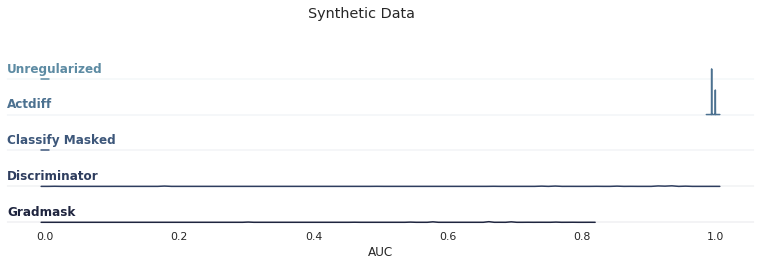

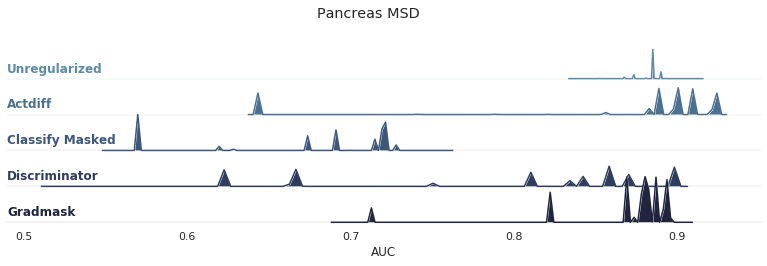

In [25]:
plot_search_space(os.path.join(results_dir, 'synth-search'), "Synthetic Data", 1234);
plot_search_space(os.path.join(results_dir, 'pancreasmsd-search'), "Pancreas MSD", 1234);

In [27]:
_df = df_performance.groupby(['experiment_name']).sum()
_df

,best_epoch,best_test_loss,best_test_score,best_train_loss,best_valid_loss,best_valid_score,n_epochs,seed,test_auc,this_epoch,valid_auc
experiment_name,,,,,,,,,,,
livermsd-search_resnet,46,0.210401,0.975403,0.079401,0.161389,0.983643,100,0,0.975403,46,0.983643
pancreasmsd-search_resnet,36,0.642271,0.838593,0.265586,0.380164,0.909882,100,0,0.838593,36,0.909882
pancreasmsd-search_resnet_actdiff,98,0.369676,0.951294,0.568297,0.401702,0.924255,100,0,0.951294,98,0.924255
pancreasmsd-search_resnet_clfmasked,17,10.053483,0.806854,0.000162,9.131866,0.756622,100,0,0.806854,17,0.756622
pancreasmsd-search_resnet_discriminator,22,0.547716,0.905273,0.415424,0.458462,0.900330,100,0,0.905273,22,0.900330
pancreasmsd-search_resnet_gradmask,91,0.393825,0.904236,0.342851,0.401759,0.903412,100,0,0.904236,91,0.903412
synth-search_resnet,5,10.564054,0.000000,0.000157,10.685141,0.000000,100,0,0.000000,5,0.000000
synth-search_resnet_actdiff,16,0.057940,0.999023,0.046101,0.014635,1.000000,100,0,0.999023,16,1.000000
synth-search_resnet_clfmasked,5,10.564054,0.000000,0.000157,10.685141,0.000000,100,0,0.000000,5,0.000000


In [18]:
_df = df_hparams.groupby(['experiment_name']).first()
_df

,dataset_train_PancreasMSDDataset_blur,dataset_train_SyntheticDataset_blur,model_ResNetModel_actdiff_lamb,model_ResNetModel_disc_iter,model_ResNetModel_disc_lamb,model_ResNetModel_disc_lr,model_ResNetModel_gradmask_lamb,model_ResNetModel_resnet_type,model_ResNetModel_save_acts,optimizer_Adam_lr
experiment_name,,,,,,,,,,
pancreasmsd-search_resnet,2.0,NaN,0.000000,NaN,0.000000,NaN,0.000000,18,[],0.000010
pancreasmsd-search_resnet_actdiff,20.0,NaN,0.001615,NaN,0.000000,NaN,0.000000,18,[5],0.000053
pancreasmsd-search_resnet_clfmasked,15.0,NaN,0.000000,NaN,0.000000,NaN,0.000000,18,[],0.000615
pancreasmsd-search_resnet_discriminator,20.0,NaN,0.000000,2.0,0.017167,0.000328,0.000000,18,[5],0.000537
pancreasmsd-search_resnet_gradmask,2.0,NaN,0.000000,NaN,0.000000,NaN,0.000100,18,[],0.000010
synth-search_resnet,NaN,9.0,0.000000,NaN,0.000000,NaN,0.000000,18,[],0.000311
synth-search_resnet_actdiff,NaN,9.0,0.114963,NaN,0.000000,NaN,0.000000,18,[5],0.000311
synth-search_resnet_clfmasked,NaN,9.0,0.000000,NaN,0.000000,NaN,0.000000,18,[],0.000311
synth-search_resnet_discriminator,NaN,2.0,0.000000,3.0,2.647180,0.000100,0.000000,18,[5],0.000022


In [186]:
# Uses the control experiments (no activmask) as the "maxmasks=0" runs for the maxmasks plots below.
#df_synth_mask = df[df['experiment_name'].str.contains('synth-masks')]
#df_synth_mask = merge_dfs_for_maxmasks(df_synth, df_synth_mask, 'synth', 'synth-masks', 10)
#df_liver_mask = df[df['experiment_name'].str.contains('livermsd-masks')]
#df_liver_mask = merge_dfs_for_maxmasks(df_liver, df_liver_mask, 'livermsd', 'livermsd-masks', 1)
#df_cardiac_mask = df[df['experiment_name'].str.contains('cardiacmsd-masks')]
#df_cardiac_mask = merge_dfs_for_maxmasks(df_cardiac, df_cardiac_mask, 'cardiacmsd', 'cardiacmsd-masks', 1)
#df_pancreas_mask = df[df['experiment_name'].str.contains('pancreasmsd-masks')]
#df_pancreas_mask = merge_dfs_for_maxmasks(df_pancreas, df_pancreas_mask, 'pancreasmsd', 'pancreasmsd-masks', 1)
#df_mask = pd.concat([df_synth_mask, df_liver_mask, df_cardiac_mask, df_pancreas_mask], axis=0)

In [ ]:
# Write table showing the results at the final epoch.
#with open('tables/synth_last_results.tex','w') as tf:
#    tf.write(get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2).to_latex())#
#
#get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2)

In [ ]:
# Write table showing best test AUC results.
#with open('tables/all_test_results.tex', 'w') as tf:
#    tf.write(make_results_table([df_synth, df_liver, df_cardiac, df_pancreas], sig_digits=2).to_latex())
#
#make_results_table([df_synth, df_liver, df_cardiac, df_pancreas], sig_digits=2)

In [ ]:
# Write table showing best test AUC results.
#with open('tables/all_xray_results.tex', 'w') as tf:
#    tf.write(make_results_table([df_xray], sig_digits=2).to_latex())
#
#make_results_table([df_xray], sig_digits=2)

In [ ]:
# Plots the Valid AUC over all epochs of the Synthetic Dataset training.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10, 6), 
                                             nrows=2, ncols=2, sharex=True, sharey=True)

palette = {
    'synth_unet': "gray", 
    'synth_unet_actdiff': "red",
    'synth_unet_clfmasked': "green",
    'synth_unet_gradmask': "blue",
    'synth_unet_actgrad': "yellow",
    'synth_unet_reconmasked': "orange"
}

g = sns.lineplot(
    x="epoch", y='valid_auc', hue='experiment_name', 
    ax=ax1, data=get_curveplot_df(df_synth, 'unet'),
    palette=palette, hue_order=sorted(list(palette.keys())))
g.set_title("UNet Experiments")
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.get_legend().remove()
g.set_ylim(-0.05, 1.05)
g.set_xlabel('Epoch')
g.set_ylabel('Valid AUC')

palette = {
    'synth_ae': "gray", 
    'synth_ae_actdiff': "red",
    'synth_ae_clfmasked': "green",
    'synth_ae_gradmask': "blue",
    'synth_ae_actgrad': "yellow",
    'synth_ae_reconmasked': "orange"
}

g = sns.lineplot(
    x="epoch", y='valid_auc', hue='experiment_name', 
    ax=ax2, data=get_curveplot_df(df_synth, 'ae'),
    palette=palette, hue_order=sorted(list(palette.keys())))
g.set_title("CNN Autoencoder Experiments")
g.legend(['Classify', 'Actdiff', 'Actgrad', 'Classify Masked', 'Gradmask', 'Reconstruct Masked'], 
          loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
g.set_ylim(-0.05, 1.05)
g.set_xlabel('Epoch')
g.set_ylabel('Valid AUC')

palette = {
    'synth_resnet': "gray", 
    'synth_resnet_actdiff': "red",
    'synth_resnet_clfmasked': "green",
    'synth_resnet_gradmask': "blue",
    'synth_resnet_actgrad': "yellow"
}

g = sns.lineplot(
    x="epoch", y='valid_auc', hue='experiment_name', 
    ax=ax3, data=get_curveplot_df(df_synth, 'resnet'),
    palette=palette, hue_order=sorted(list(palette.keys())))
g.set_title("ResNet 18 Experiments")
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.get_legend().remove()
g.set_ylim(-0.05, 1.05)
g.set_xlabel('Epoch')
g.set_ylabel('Valid AUC')

palette = {
    'synth_cnn': "gray", 
    'synth_cnn_actdiff': "red",
    'synth_cnn_clfmasked': "green",
    'synth_cnn_gradmask': "blue",
    'synth_cnn_actgrad': "yellow",
}

g = sns.lineplot(
    x="epoch", y='valid_auc', hue='experiment_name', 
    ax=ax4, data=get_curveplot_df(df_synth, 'cnn'),
    palette=palette, hue_order=sorted(list(palette.keys())))
g.set_title("CNN Experiments")
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.get_legend().remove()
g.set_ylim(-0.05, 1.05)
g.set_xlabel('Epoch')
g.set_ylabel('Valid AUC')

fig.set_tight_layout(tight=True)

In [ ]:
# Gets the best test auc (early stopping) for all masks experiments.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10, 6), 
                                             nrows=2, ncols=2, sharex=True, sharey=True)

palette = {
    'synth-masks_unet_gradmask': "red", 
    'synth-masks_unet_actdiff': "lightcoral",
    'synth-masks_resnet_gradmask': "blue",
    'synth-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax1, data=get_lineplot_df(df_synth_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Synth")
g.set(ylim=(0.5, 1.05))
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Test AUC')

palette = {
    'livermsd-masks_unet_gradmask': "red", 
    'livermsd-masks_unet_actdiff': "lightcoral",
    'livermsd-masks_resnet_gradmask': "blue",
    'livermsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax2, data=get_lineplot_df(df_liver_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Liver")
g.set(ylim=(0.5, 1.0))
g.legend(['ResNet Actdiff', 'ResNet Gradmask', 'UNet Actdiff', 'UNet Gradmask'], 
         loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Test AUC')


palette = {
    'cardiacmsd-masks_unet_gradmask': "red", 
    'cardiacmsd-masks_unet_actdiff': "lightcoral",
    'cardiacmsd-masks_resnet_gradmask': "blue",
    'cardiacmsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax3, data=get_lineplot_df(df_cardiac_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Cardiac")
g.set(ylim=(0.5, 1.0))
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Test AUC')


palette = {
    'pancreasmsd-masks_unet_gradmask': "red", 
    'pancreasmsd-masks_unet_actdiff': "lightcoral",
    'pancreasmsd-masks_resnet_gradmask': "blue",
    'pancreasmsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax4, data=get_lineplot_df(df_pancreas_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Pancreas")
g.set(ylim=(0.5, 1.0))
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Test AUC')



fig.set_tight_layout(tight=True)

In [ ]:
# Gets the best epoch (early stopping) for all masks experiments.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10, 6), 
                                             nrows=2, ncols=2, sharex=True, sharey=True)

palette = {
    'synth-masks_unet_gradmask': "red", 
    'synth-masks_unet_actdiff': "lightcoral",
    'synth-masks_resnet_gradmask': "blue",
    'synth-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax1, data=get_lineplot_df(df_synth_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Synth")
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Epoch')


palette = {
    'livermsd-masks_unet_gradmask': "red", 
    'livermsd-masks_unet_actdiff': "lightcoral",
    'livermsd-masks_resnet_gradmask': "blue",
    'livermsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax2, data=get_lineplot_df(df_liver_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Liver")
g.legend(['ResNet Actdiff', 'ResNet Gradmask', 'UNet Actdiff', 'UNet Gradmask'],
          loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Epoch')


palette = {
    'cardiacmsd-masks_unet_gradmask': "red", 
    'cardiacmsd-masks_unet_actdiff': "lightcoral",
    'cardiacmsd-masks_resnet_gradmask': "blue",
    'cardiacmsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax3, data=get_lineplot_df(df_cardiac_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Cardiac")
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Epoch')


palette = {
    'pancreasmsd-masks_unet_gradmask': "red", 
    'pancreasmsd-masks_unet_actdiff': "lightcoral",
    'pancreasmsd-masks_resnet_gradmask': "blue",
    'pancreasmsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax4, data=get_lineplot_df(df_pancreas_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Pancreas")
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Epoch')

fig.set_tight_layout(tight=True)

# Datasets

In [37]:
d_synth = SyntheticDataset(mode='distractor3', dataroot='/home/jdv/code/activmask/data/synth2')
d_heart = HeartMSDDataset(base_path='/srv/data/msd', mode='test', nsamples=10, blur=4)
d_liver = LiverMSDDataset(base_path='/srv/data/msd', mode='test', nsamples=1000, blur=4)
d_pancr = PancreasMSDDataset(base_path='/srv/data/msd', mode='test', nsamples=1000, blur=4)
d_xray = JointDataset(
    "/srv/data/xray/NIH/images-128",
    "/srv/data/xray/Data_Entry_2017.csv",
    "/srv/data/xray/PC/images-128",
    "/srv/data/xray/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv",
    mode='test', seed=1234, ratio=0.9, new_size=128)


Full dataset contains: Counter({True: 1351, False: 920})
mode=test
Loading 8 files:['la_017.nii.gz', 'la_014.nii.gz', 'la_024.nii.gz', 'la_019.nii.gz', 'la_007.nii.gz', 'la_003.nii.gz', 'la_023.nii.gz', 'la_020.nii.gz']
Loaded images contain:Counter({True: 540, False: 400})
This dataloader contains: Counter({True: 5, False: 5})
Full dataset contains: Counter({False: 39476, True: 19162})
mode=test
Loading 53 files:['liver_49.nii.gz', 'liver_13.nii.gz', 'liver_119.nii.gz', 'liver_48.nii.gz', 'liver_126.nii.gz', 'liver_80.nii.gz', 'liver_32.nii.gz', 'liver_82.nii.gz', 'liver_83.nii.gz', 'liver_127.nii.gz', 'liver_81.nii.gz', 'liver_110.nii.gz', 'liver_63.nii.gz', 'liver_115.nii.gz', 'liver_124.nii.gz', 'liver_25.nii.gz', 'liver_79.nii.gz', 'liver_55.nii.gz', 'liver_39.nii.gz', 'liver_99.nii.gz', 'liver_52.nii.gz', 'liver_43.nii.gz', 'liver_53.nii.gz', 'liver_116.nii.gz', 'liver_93.nii.gz', 'liver_46.nii.gz', 'liver_50.nii.gz', 'liver_120.nii.gz', 'liver_14.nii.gz', 'liver_54.nii.gz', 'liv

FileNotFoundError: [Errno 2] File b'/srv/data/xray/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv' does not exist: b'/srv/data/xray/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv'

Salience Maps
---------------------

In [ ]:

mdl = torch.load("/home/jdv/code/activmask/results/xray-search_resnet_actdiff_1234.pth.tar", map_location='cpu')

def render_grad(dataset, mdl):
    
    # Configure plots.
    fig, axs = plt.subplots(nrows=1, ncols=1, 
                           figsize=(4, 4), dpi=150, 
                           gridspec_kw={'hspace': 0.15, 'wspace': 0.01})
    fig.subplots_adjust(wspace=0.0)
    for a in ax:
        for aa in a:
            aa.axis('off')

    # Prepare the Image.            
    idx = np.random.randint(1000)
    x, y, use_mask = dataset[idx]
    img = x[0][0].cpu().numpy()
    img /= np.max(img)
    seg = x[1][0].cpu().numpy() 
    
    # Required for Grad computation.
    x_var = torch.autograd.Variable(x[0].unsqueeze(0),
                                    requires_grad=True)

    # Saliency calculation.
    y_prime, x_prime = mdl(x_var)
    gradients = get_grad_contrast(x_var, y_prime, y).detach().cpu().numpy()[0][0]
    gradients *= (gradients > np.percentile(gradients, 90))
    
    grad_cmap = plt.cm.jet
    grad_cmap.set_under('k', alpha=0)

    for ax in axs:
        ax.set_title(name)
        ax.imshow(img, interpolation='none', cmap='Greys_r')
        ax.imshow(gradmask, interpolation='none', cmap=my_cmap, clim=[0.000001, gradmask.max()])
        ax.axis('off')  

        
    plt.show()
render_grad(dataset, mdl)


In [ ]:
name, resnet, unet = models_toplot[2]
print(name)
gradz = []
for s in d:
    x,_,_ = s
    x = torch.tensor(x[0])
    x_var = torch.autograd.Variable(x.unsqueeze(0),requires_grad=True)
    y_prime, x_prime = resnet(x_var)
    gradmask = get_gradmask_loss(x_var, y_prime, resnet, torch.tensor(1.),
                                         "contrast").detach().cpu().numpy()[0][0]
    gradz.append(gradmask)

toagg = np.asarray(gradz)
toagg = toagg[d.labels==True]
plt.imshow(np.abs(toagg.mean(0)), cmap="jet", interpolation='none')
plt.title("Avg grad: " + name + " resnet, test N=" + str(len(gradz)));

In [ ]:
render_salience_maps("aaa", "", sample, cnn, resnet, unet, "a")

# Mean Saliency Maps / Dataset-Level Stats

In [ ]:
results_dir = "/home/jdv/code/activmask/results.bak"
model_name = "last_model_1234.pth.tar"

base_mdl = load_model(os.path.join(results_dir, "synth-search_resnet/{}".format(model_name)))
disc_mdl = load_model(os.path.join(results_dir, "synth-search_resnet_discriminator/{}".format(model_name)))
actd_mdl = load_model(os.path.join(results_dir, "synth-search_resnet_actdiff/{}".format(model_name)))
grad_mdl = load_model(os.path.join(results_dir, "synth-search_resnet_gradmask/{}".format(model_name)))
render_mean_grad(dataset, base_mdl, disc_mdl, actd_mdl, grad_mdl, 'Synthetic', img_size=28)

In [ ]:
#dataset = datasets.MSDDataset.PancreasMSDDataset(mode='test', nsamples=NSAMPLES, blur=16)